# Practice Session 08: Data streams

In this session we will take a large corpus of queries and compute statistics on them using methods for data stream sampling.

# 0. Preliminaries

The dataset we will use contains the most 1,000 prolific users from the AOL Query Log (2006), a dataset released for research, and later retracted [[download link](https://github.com/wasiahmad/aol_query_log_analysis)]. The idea of this practice is to obtain some statistics on this file **without** storing parts of the file in main memory.

## 0.1. Required imports

In [2]:
import io
import csv
import math
import random
import statistics

## 0.2. How to iterate through this file

In [4]:
INPUT_FILE = "Datasets/user_queries.csv"
with io.open(INPUT_FILE) as file:
    reader = csv.reader(file, delimiter="\t")
    for timestamp, userid, query in reader:
        # Prints 0.01% of lines
        if random.random() < 0.0001:
            print("On %s user %s issued query %s" % (timestamp, userid, query)) 

On 2006-03-01 22:36:30 user u923311 issued query is travis stork with the girl he chose
On 2006-03-02 14:43:00 user u6001085 issued query sport aktuell
On 2006-03-04 06:34:14 user u6438440 issued query modern coffee tables
On 2006-03-05 07:11:06 user u3975128 issued query google
On 2006-03-08 06:25:05 user u7341676 issued query small group ministry
On 2006-03-08 19:10:33 user u7050479 issued query the life of st francis
On 2006-03-11 22:29:04 user u3765764 issued query organic groceries
On 2006-03-15 08:18:04 user u686808 issued query sunscreen babies
On 2006-03-17 21:57:58 user u7692143 issued query lactose free lasagne
On 2006-03-18 14:11:55 user u793903 issued query the bra page
On 2006-03-22 13:51:07 user u51799 issued query bakelite jewelry
On 2006-03-22 18:32:26 user u1402470 issued query lego
On 2006-03-26 20:35:20 user u9029572 issued query danielle panabaker fansites
On 2006-03-27 23:48:22 user u2552491 issued query new jersey escort courtesan
On 2006-03-28 12:57:48 user u2741

# 1. Determine approximately the top-5 queries

In this query log the most frequent queries are:

* "google" (1.6% of the queries)
* "ebay" (1.5%)
* "yahoo" (1.3%)
* "myspace" (1.0%)
* "craigslist" (0.5%)

Instead of loading the entire query log in main memory, we will use reservoir sampling to determine approximately the top-5 queries.

**Reservoir sampling**: In reservoir sampling, if we have a reservoir of size S:

* We store the first S elements of the stream
* When the n<sup>th</sup> element arrives (let's call it X<sub>n</sub>):
   * With probability 1 - s/n, we ignore this element.
   * With probability s/n, we:
      * Discard a random element from the reservoir
      * Add element X<sub>n</sub> to the reservoir (calling *add_to_reservoir*)

[**CODE**] Implement a function `add_reservoir(reservoir, item, max_size)` that adds an item to the reservoir, maintaining its size. If the reservoir is already of size *max_size*, a random item is selected and evicted *before* adding the item. It is important to evict an old item *before* adding the new item.

In [5]:
def add_to_reservoir(reservoir, item, max_reservoir_size):
    # YOUR CODE HERE
    assert(len(reservoir) <= max_reservoir_size)
    reservoir.remove(random.choice(reservoir))
    reservoir.append(item)

[**CODE**] Iterate through the file using the reservoir sampling method seen in class. In this function you will decide, for every item, whether to call *add_to_reservoir* or to ignore the item.

In [24]:
def reservoir_sampling(filename, reservoir_size):
    reservoir = []

    with io.open(filename) as file:
        reader = csv.reader(file, delimiter="\t")
        i = 0
        for timestamp, userid, query in reader:
            i += 1
            # YOUR CODE HERE: decide whether to call add_to_reservoir or not
            if len(reservoir) == reservoir_size:
                add_to_reservoir(reservoir, query, reservoir_size)
            else:
                reservoir.append(query)                       
                
    return i, reservoir

num_lines, reservoir = reservoir_sampling(INPUT_FILE, 500)

print("Number of queries seen    : %d" % num_lines)
print("Number of queries sampled : %d" % len(reservoir) )

Number of queries seen    : 318023
Number of queries sampled : 500


[**CODE**] Write code to list the top-5 queries found by looking at frequencies in the reservoir. If you see a query C times in the reservoir, you can estimate the query appears *C x dataset_size / reservoir_size* times in the entire dataset (*dataset_size* is the size of the entire dataset). Dividing this quantity by *dataset_size* and multiplying by 100 will give you the percentage.

In [25]:
#MY OUTPUT
freq = {}
for item in reservoir:
    freq[item] = reservoir.count(item)

most_frequent_items = sorted([(frequency, query) for query, frequency in freq.items()], reverse=True)[:5]
for item in most_frequent_items:
    print(item[1], str(100 * item[0]/len(reservoir)) + '%')

myspace 2.4%
middle school reading lists 1.4%
google 1.2%
scottish highland dancing 1.0%
ebay 1.0%


[**REPORT**] For various sizes of the reservoir: 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, list the top-5 queries and their estimated frequency. 

[**REPORT**] Find by trial and error, and include in your report, the minimum reservoir size you would have to use to have an overlap of 3/5 between the queries found by the approximate method and the actual top-5.

In [27]:
trials = '10,20,50,100,200,500,1000,2000,5000'.split(',')

for number in trials:
    num_lines, reservoir = reservoir_sampling(INPUT_FILE, int(number))
    print('For a reservoir of size', number)
    freq = {}
    for item in reservoir:
        freq[item] = reservoir.count(item)
    most_frequent_items = sorted([(frequency, query) for query, frequency in freq.items()], reverse=True)[:5]
    for item in most_frequent_items:
        print(item[1], str(100 * item[0]/len(reservoir)) + '%')
    print('------------')

For a reservoir of size 10
young teens top-sites 10.0%
steele foundation 10.0%
scottish highland dancing 10.0%
myspace 10.0%
mastercook.com gi recipes 10.0%
------------
For a reservoir of size 20
scottish highland dancing 15.0%
winter sheild songs 5.0%
watch winders wolf 5.0%
steele foundation 5.0%
shelf talker signs 5.0%
------------
For a reservoir of size 50
scottish highland dancing 6.0%
young teens top-sites 2.0%
www.online-sweepstakes.com 2.0%
www.ny1.com 2.0%
white gold anklets 2.0%
------------
For a reservoir of size 100
myspace 4.0%
scottish highland dancing 3.0%
nudist swinger beach 3.0%
popular baby names 2.0%
lowest gi recipes 2.0%
------------
For a reservoir of size 200
scottish highland dancing 2.5%
myspace 2.0%
sexy swimwear 1.5%
google 1.5%
yahoo 1.0%
------------
For a reservoir of size 500
myspace 1.6%
yahoo 1.4%
google 1.2%
scottish highland dancing 1.0%
swimsuit models 0.8%
------------
For a reservoir of size 1000
ebay 1.2%
myspace 1.1%
msn 1.1%
middle school re

# 2. Determine approximately the number of users

We will estimate the number of distinct users without creating a dictionary or hash table with users, but instead, we will use the Flajolet-Martin probabilistic counting method.

**Flajolet-Martin probabilistic counting**:

* For several passes
   * Create hash funcion h
   * For every element *u* in the stream:
      * Compute hash value *h(u)*
      * Let *r(u)* be the number of trailing zeroes in *h(u)*
      * Maintain *R* as the maximum value of *r(u)* seen so far
   * Add *2<sup>R</sup>* as an estimate for the number of distinct elements *u* seen
* The final estimate is the average or the median of the estimates found in each pass

Use this function to count trailing zeroes in the binary representation of a number.

In [96]:
def count_trailing_zeroes(number):
    count = 0
    while number & 1 == 0:
        count += 1
        number = number>>1
    return count

Use this function to generate a random hash function. Note this generates a function, so you can do `hash_function = random_hash_function()` and then call `hash_function(x)` to compute the hash value of `x`.

In [67]:
def random_hash_function():
    salt = random.random()
    return lambda string: hash(string + str(salt))

[**CODE**] Perform *number_of_passes* passes over the file, reading the entire file on each pass (we don't use the reservoir in this part). In each pass, create a new hash function and use it to hash userids. Keep the maximum number of trailing zeroes seen in the hash value of a userid. 

In [108]:
#MY OUTPUT
number_of_passes = 10

estimates = []

for i in range(number_of_passes):
    # YOUR_CODE_HERE: read the file and generate an estimate
    with io.open(INPUT_FILE) as file:
        reader = csv.reader(file, delimiter="\t")
        buffer = []
        for timestamp, userid, query in reader:
            hash_function = random_hash_function()
            buffer.append(count_trailing_zeroes(hash_function(userid)))
    estimate = 2**(max(buffer)>>1)
    estimates.append(estimate)
    print("Estimate on pass %d: %d" % (i+1,estimate))
    
print("* Average of estimates: %.1f" % statistics.mean(estimates))
print("* Median  of estimates: %.1f" % statistics.median(estimates))

Estimate on pass 1: 512
Estimate on pass 2: 512
Estimate on pass 3: 1024
Estimate on pass 4: 512
Estimate on pass 5: 512
Estimate on pass 6: 512
Estimate on pass 7: 512
Estimate on pass 8: 512
Estimate on pass 9: 4096
Estimate on pass 10: 256
* Average of estimates: 896.0
* Median  of estimates: 512.0


[**REPORT**] Include in your report the median of estimates obtained in 3 separate runs of your algorithm; each run should do 10 passes over the file. Indicate why the median of estimates is preferable to the average of estimates.

*Note: in this dataset, the actual number of users is 1000.*

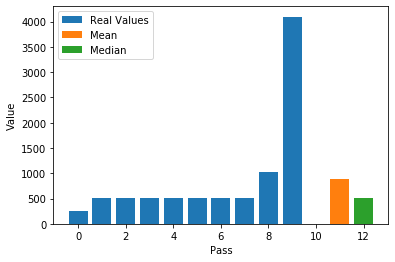

In [109]:
import matplotlib.pyplot as plt
import numpy as np

estimates.sort()
plt.bar(np.arange(0,number_of_passes), estimates, label='Real Values')
plt.bar(number_of_passes+1, statistics.mean(estimates), label='Mean')
plt.bar(number_of_passes+2, statistics.median(estimates), label='Median')
plt.ylabel('Value')
plt.xlabel('Pass')
plt.legend(loc='best')
plt.show()

# 3. Deliver

Deliver:

* A zip file containing your notebook (.ipynb file) with all the [**CODE**] parts implemented.
* A 2-pages PDF report including all parts of this notebook marked with "[**REPORT**]"
The report should end with the following statement: **I hereby declare that, except for the code provided by the course instructors, all of our code, report, and figures were produced by myself.**